In [1]:
from argparse import ArgumentParser
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as T
from tqdm.auto import tqdm

from training_pipeline import calculate_epoch_metrics, do_phase, get_dataloaders, initialize_model
from models import *

Using device cpu


In [2]:
MODEL_NAME = 'resnet' # or 'densenet' or whatever
DATASET = 'mnist' # or 'camelyon17' or 'iwildcam'
CORRELATION = 0.3

In [3]:
def get_model(model_file):
    model, _ = initialize_model(
         MODEL_NAME,
         2, # num classes is always 2
         True, # set this feature extraction flag to true to freeze stuff
         use_pretrained=False
    )
    try:
        weights = torch.load(model_file).state_dict() 
    except Exception: # need to extract the state dict from the model file
        weights = torch.load(model_file)
    model.load_state_dict(weights)
    model.eval()
    return model

def get_dataloader(correlation):
    _, test_dl = get_dataloaders(
        DATASET,
        "/scratch/eecs542f21_class_root/eecs542f21_class/shared_data/dssr_datasets/WildsData/camelyon17_v1.0",
        CORRELATION,
        42, # seed
        32, # batch_size
        os.cpu_count() // 2,
        test_only=True,
    )
    return test_dl

def run_inference(model, dataloader):
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    _, _, all_y, all_preds, all_scores, _, all_domains, all_domain_preds, all_domain_scores = do_phase('val', model, pbar)
    return all_y, all_preds, all_scores, all_domains, all_domain_preds, all_domain_scores

def compare_predictions(baseline_model, skewed_model, correlation):
    print("Loading datasets...")
    dl = get_dataloader(correlation)
    
    print("Running inference...")
    results_base = run_inference(baseline, dl)
    results_skewed = run_inference(skewed, dl)
    _, preds_base, all_domains, *_ = results_base
    _, preds_skewed, *_ = results_skewed
    # TODO: maybe store the rest of the results and compute metrics, idk
    return preds_base, preds_skewed, dl.dataset # this only works because shuffle = False

In [4]:
BASELINE_PATH = "/scratch/eecs542f21_class_root/eecs542f21_class/shared_data/dssr_datasets/saved_models/mnist_corr_0.5__bestacc_0.8379860418743769.pth"
SKEWED_PATH = "/scratch/eecs542f21_class_root/eecs542f21_class/shared_data/dssr_datasets/saved_models/mnist_corr_0.7__bestacc_0.8569292123629113.pth"
CORRELATION_SOURCE = 0.5

print("Loading model...")
baseline = get_model(BASELINE_PATH)
skewed = get_model(SKEWED_PATH)
preds_base, preds_skewed, dataset = compare_predictions(baseline, skewed, CORRELATION_SOURCE)


Loading model...
Loading datasets...
Running inference...


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

# of examples in group: 777
# of examples total: 2006


/home/ctrenton/miniconda3/envs/eecs542/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


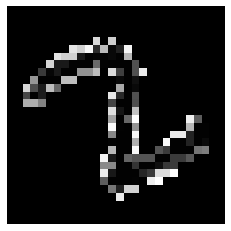

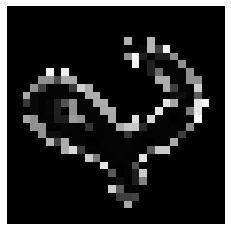

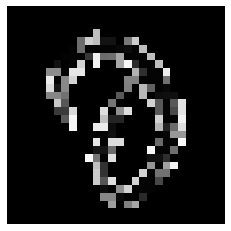

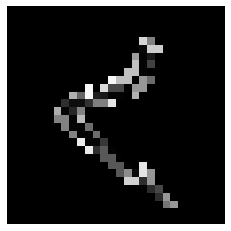

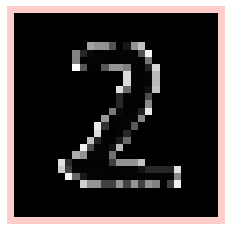

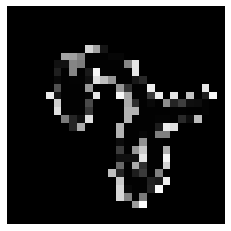

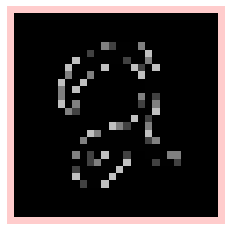

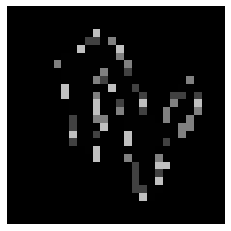

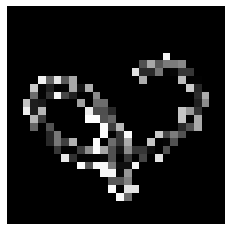

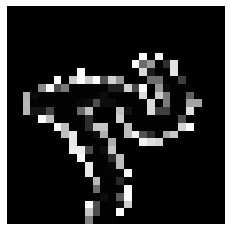

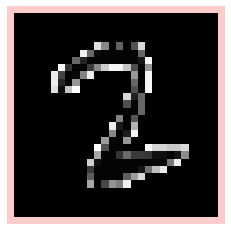

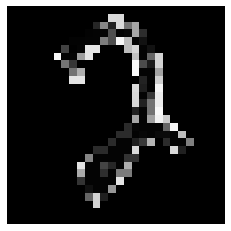

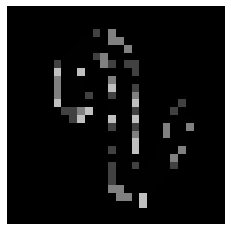

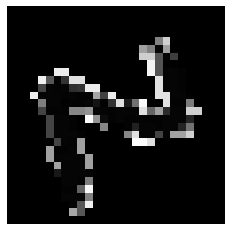

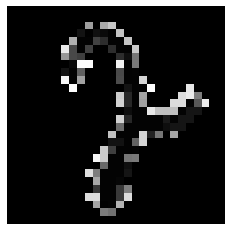

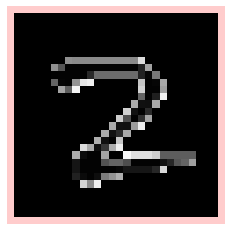

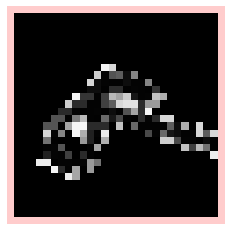

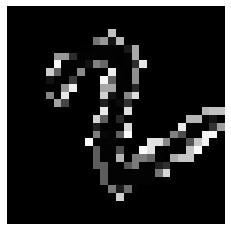

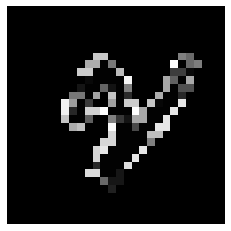

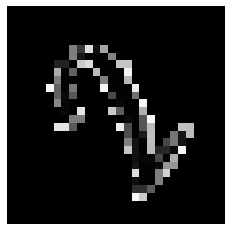

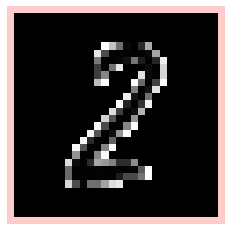

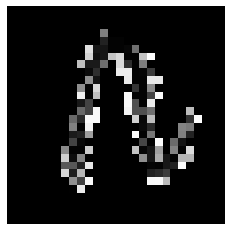

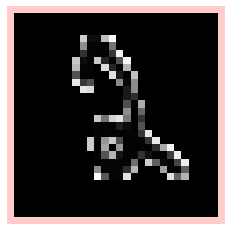

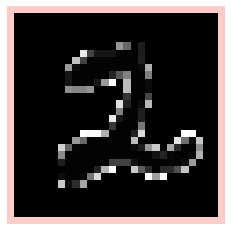

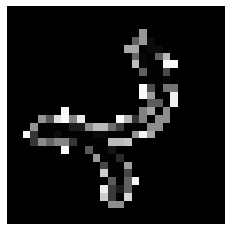

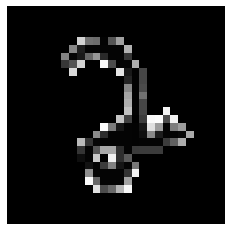

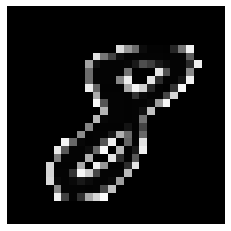

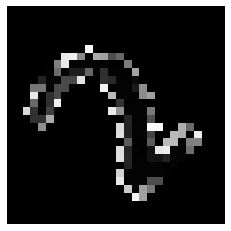

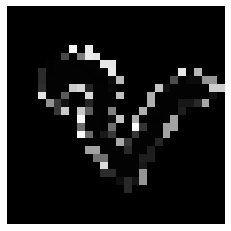

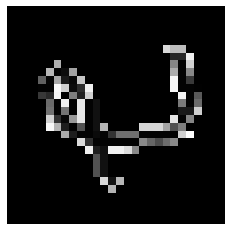

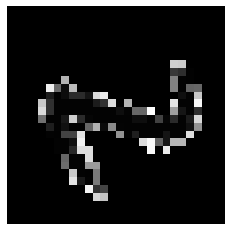

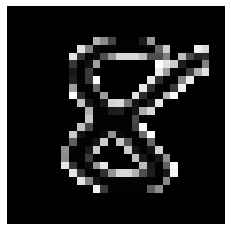

In [45]:
N_EXAMPLES_TO_VISUALIZE = 32
EXAMPLE_TYPE = 'hard' # or 'robust' or 'hard'

np.random.seed(42) # change this to see diff examples -- for reproducibility. Original is 42.

if EXAMPLE_TYPE == 'flipped':
    preds = (preds_base == 1) & (preds_skewed == 0) 
elif EXAMPLE_TYPE == 'robust':
    preds = (preds_base == 1) & (preds_skewed == 1)
elif EXAMPLE_TYPE == 'hard':
    preds = (preds_base == 0) & (preds_skewed == 0) 
    
print("# of examples in group:", preds.sum().item())
print("# of examples total:", len(preds))

indices = np.random.choice(np.where(preds.squeeze() == 1)[0], N_EXAMPLES_TO_VISUALIZE)

def frame_image(img, frame_width, color="#ffcccc"):
    b = frame_width # border size in pixel
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    framed_img = np.zeros((nx+2*b, ny+2*b, 3), dtype=int)
    framed_img[..., 0] = int(f"0x{color[1:3]}", 16)
    framed_img[..., 1] = int(f"0x{color[3:5]}", 16)
    framed_img[..., 2] = int(f"0x{color[5:]}", 16)
    framed_img[b:-b, b:-b] = img
    return framed_img

def show_spurious_correlations(indices, frame=True, spurious_class1_color="#ffcccc", spurious_class0_color="#ffcccc", border_width=1):
    for i in indices:
        X, y, z = dataset[i]
        img = np.array(T.to_pil_image(X)).astype(int)
        fig = plt.figure(figsize=(4, 4))
        ax = fig.subplots(1, 1)
        axis = ax.axis()
        if frame:
            if y == 1 and z == 1: # fooled by spurious correlation, class 1
                img = frame_image(img, border_width, color=spurious_class1_color)
            if y == 0 and z == 0: # fooled by spurious correlation, class 0
                img = frame_image(img, border_width, color=spurious_class0_color)
        ax.set_axis_off()
        ax.imshow(img)

show_spurious_correlations(indices)


In [ ]:
# right-click to save images for figures